# 3 Usefulness
## 3.1 Predictive Model Performance
1. The original and synthetic evaluation samples are further divided into a test sample (90% of evaluation sample) and train sample (10% of evaluation sample). Categorical columns are one-hot-encoded, so all datas are numbers.  
2. A series of $ N $ commonly used predictive models (Random Forests, Linear Regression…) are trained on the train samples for both the real and the synthetic data and applied to the test samples. Suppose there are _n_ columns, the predictive model attempts to predict each column based on the rest _(n-1)_ of the columnss. For different tasks, TSTR or TSTS & TRTR is applied.
    * TSTR: we calculate the error $ e_{i} $ (in this code we use MSE) for each column $ i $,  calculate the -- see _section II._
    $$
    E = \frac { \sum_{i=1}^{n} e_{i}}{n} 
    $$
        The lower the _E_, the better the synthetic data.
        
    * TSTS & TRTR: we calculate the error $ e_{i,j} $ (real) and $ e'_{i,j} $ (synthetic) for each column _i_ and predictive model _j_. There are two ways to compare TSTS and TRTR:      
        * We want to see if a model performs better than another model on the real data, whether or not it performs better on the synthetic data as well. We calculate $ E_{j} $ and $ E'_{j} $ for every model $ j $ and use a measuring quantity called $ SRA $ (Synthetic Ranking agreement) between lists $ (E)_{j=1}^{N} $ and $ (E')_{j=1}^{N} $  . SRA measures the proportion of agreed ranking, the higher the SRA, the better the synthetic data.  (see 1.3 for detailed explanation of SRA) -- see _section III._
       
        * We can also use SRA to measure the list of $ (e)_{i=1}^{n} $ for each column predicition results, for the specified model and synthetic data generator. -- see _section IV._
        * We want to see for a model $ j $, whether they generate similar error or not. We work 
        $$
        \epsilon _{j} = \sum_{i=1}^{n} (e_{i,j}-e'_{i,j})^2, 
        $$ 
          the lower the quantity, the better the synthetic data. -- see _section V._
          
* How to deal with 'NaN'?
    * For categorical columns which proportion of NaN in is significant (e.g. over 10%), treating NaN values as a category.
    * For columns which proportion of NaN in is insignificant, deleting samples with an NaN in such columns.
    * For numerical columns which proportion of NaN in is significant, fill NaN with 0. (Luckily we don't have too many such columns in the PRISM dataset and it makes sense to do so)

## I. Import and Pre-Process the data

In [14]:
import numpy as np
import pandas as pd
dp_ori_df = pd.read_csv('synthetic data/doppelGANger/dp_ori.csv') #originally ori_features_prism.npy
dp_gen_df = pd.read_csv('synthetic data/doppelGANger/dp_gen.csv') #originally features_600.npy
tgan_ori_df = pd.read_csv('synthetic data/TGAN/tgan_ori.csv') #originally cat_time_10visits_all_noid.csv
tgan_gen_df = pd.read_csv('synthetic data/TGAN/tgan_gen.csv') #originally gen_cat_time_10visits_wl_5000it.npy
ori_df = pd.read_csv('synthetic data/2_no_id/ori_df.csv') #originally cat_time_5abovevisits_all.csv
gen_1_df = pd.read_csv('synthetic data/2_no_id/gen_1_df.csv') #originally gen_cat_time_10visits_wl_5000it_hd10_nl5.npy
gen_2_df = pd.read_csv('synthetic data/2_no_id/gen_2_df.csv') #originally gen_cat_time_10visits_wl_5000it_hd10.npy
gen_3_df = pd.read_csv('synthetic data/2_no_id/gen_3_df.csv') #originally gen_dop_cat_5abovevisits_d2g_e449.npy
gen_4_df = pd.read_csv('synthetic data/2_no_id/gen_4_df.csv') #originally from gen_cat_time_10visits_all_5000it.npy.
# all in 2d

In [15]:
#remove all-zero rows, as lots of trivial all-zero rows can bias the result heavily
#Only dp_ have lots of padded zeros
dp_ori_nozero = dp_ori_df[np.any(abs(dp_ori_df)!=0,axis=1)].copy()
dp_gen_nozero = dp_gen_df[np.any(abs(dp_gen_df)!=0,axis=1)].copy()

In [19]:
#keep numerical variables only
tgan_ori_num = tgan_ori_df.iloc[:,:6].dropna()
tgan_gen_num = tgan_gen_df.iloc[:,:6].dropna()
ori_num = ori_df.iloc[:,:6].dropna()
gen_1_num = gen_1_df.iloc[:,:6].dropna()
gen_2_num = gen_2_df.iloc[:,:6].dropna()
gen_3_num = gen_3_df.iloc[:,:6].dropna()
gen_4_num = gen_4_df.iloc[:,:6].dropna()

In [20]:
#Set up a dictionary for furture loop
synthetic_num_dic = {'DoppelGANger ini':[dp_ori_nozero,dp_gen_nozero],'tGAN':[tgan_ori_num,tgan_gen_num],\
                      'gen 1':[tgan_ori_num,gen_1_num],'gen 2':[tgan_ori_num,gen_2_num],'gen 3':[ori_num,gen_3_num],\
                      'gen 4':[tgan_ori_num,gen_4_num]}
syn_keys = list(synthetic_num_dic.keys())
n = len(syn_keys)

In [21]:
def SRA(R,S):
    '''Calculate the SRA
    
    Args:
    - R: A list of values (e.g. performance metrics of different predictive models) from TSTS
    - S: A list of values (e.g. performance metrics of different predictive models) from TRTR, len(S)=len(R)
    
    Returns:
    - SRA: SRA value
    
    '''
    def identity_function(statement):
        v = 0
        if statement:
            v = 1
        return v
            
    k = len(R)
    sum_ = 0
    for i in range(k):
        for j in range(k):
            if i != j:
                if (R[i]-R[j])==0:
                    if (S[i]-S[j])==0:
                        agree = True
                    else:
                        agree = False
                else:
                    agree = (R[i]-R[j])*(S[i]-S[j])>0
                sum_ += identity_function(agree)
    SRA = sum_ / (k*(k-1))
    return SRA

In [22]:
def DataDivide(data,rate=0.75):
    import numpy as np
    """divides the dataset to two sets, after random permutation of samples 
  
  Args:
    - data: original data
    - rate: the volumn of the first set/ the volumn of the original dataset
    
  Returns:
    - data1: the first dataset after division
    - data2: the second dataset
  """
    no = len(data)
    idx = np.random.permutation(no)
    idx1 = idx[:int(no*rate)]
    idx2 = idx[int(no*rate):]
    
    if type(data)==np.ndarray:
        data1 = data[idx1]
        data2 = data[idx2]
    else:
        data1 = data.iloc[idx1,:]
        data2 = data.iloc[idx2,:]
    
    return data1, data2

In [32]:
class Prediction:
    def __init__(self,df,df2=None):
        import numpy as np
        import pandas as pd
        if type(df2) != pd.core.frame.DataFrame: 
            #so the class is suitable for both TSTR and TSTS&TRTR purpose depending on how many dataframs are initialised. 
            #If there is only one 'df', then it will carry on training on this df and testing on this df;
            #If there is another 'df2', then it will train on df and test on df2, so this is for TSTR purporse
            self.df_train, self.df_test = DataDivide(df)
        else:
            self.df_train, _1= DataDivide(df)
            _2, self.df_test = DataDivide(df2)
        self.keys = (df.keys()).tolist()

    def ColumnPrepare(self,column_name):
        #We want to predict column 'column_name' from other columns, so X is values from other columns,
        #y is values from column 'column_name'; _train variables are used to train models (supervised learning),
        #_test variables are used to test models
        keys = self.keys.copy()
        keys.remove(column_name)
        keys_removed = keys
        
        X_train = self.df_train[keys_removed].values
        y_train = self.df_train[column_name].values
        X_test = self.df_test[keys_removed].values
        y_test = self.df_test[column_name].values
        return X_train, y_train, X_test, y_test
    
    def PredictionColumnWise(self,method):
        from sklearn.linear_model import LinearRegression
        from sklearn.tree import DecisionTreeRegressor
        from sklearn.svm import LinearSVR
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.neighbors import KNeighborsRegressor
        '''
        Train predictive models specified by 'method' arg to predict each column from other columns
        Args:
        method: ='LR','DTR','SVM','RFR', refering to different predictive models
        
        Returns: dataframe consisting of y_test (label) and y_predict (predicted results) for each column
        '''
        name_index_1 = []
        name_index_2 = ['y_test','y_pred']*len(self.keys)
        first = True
        for column_name in self.keys:
            X_train, y_train, X_test, y_test = self.ColumnPrepare(column_name)
            
            if method == 'LR':
                reg = LinearRegression()
            if method == 'DTR':
                reg = DecisionTreeRegressor()
            if method == 'SVM':   
                reg = LinearSVR()
            if method == 'RFR':
                reg = RandomForestRegressor()
            if method == 'KNR1':
                reg = KNeighborsRegressor(radius = 1)
            if method == 'KNR5':
                reg = KNeighborsRegressor(radius = 5)
            reg.fit(X_train, y_train)    
            y_pred = reg.predict(X_test)
            value_temp = np.concatenate((y_test[:,np.newaxis],y_pred[:,np.newaxis]),axis = 1)
            value_temp = value_temp.T
            
            if first:
                value = value_temp
                first = False
            else:
                value = np.concatenate((value,value_temp),axis = 0)
            name_index_1 += [column_name]*2
        index = pd.MultiIndex.from_arrays([name_index_1,name_index_2])
        return pd.DataFrame(value.T, columns = index )
    
    def Evaluation_MSE(self,method,aver = False):
        '''
        Args:
        method: ='LR','DTR','SVM','RFR', refering to different predictive models
        
        Returns:
        The User can choose to return a series of MSEs for each column by leaving aver == False, 
        if aver == True, then the return is the 'E' i.e. average of MSEs for each column
        '''
        
        from sklearn.metrics import mean_squared_error
        Presult = self.PredictionColumnWise(method)
        n = len(self.keys)
        MSE = np.array([0.5]*n)
        k=0
        for column_name in self.keys:
            y_pred = Presult[column_name]['y_pred']
            y_test = Presult[column_name]['y_test']
            MSE[k] = mean_squared_error(y_pred, y_test)
            k+=1
        MSE_series = pd.Series(MSE, index = self.keys) # The e_i's for every column
        E = np.sum(MSE_series)/len(MSE_series) # The 'E' for this model
        if aver:
            return E
        else:
            return pd.Series(MSE, index = self.keys)

In [61]:
def Comparison_Table(df_dic,models = ['LR','DTR','SVM','RFR','KNR1','KNR5']):
    '''
    The dataframe values are E's for the index model which is trained and tested on the dataset in that column.
    '''
    keys = list(df_dic.keys())
    v_np = np.zeros((len(models),len(keys)*2))
    keys_index= []
    for k in keys:
        keys_index += [k]*2
    type_index = ['ori','gen']*len(keys)
    column_multi = np.array([keys_index,type_index])
    column_multi = pd.MultiIndex.from_arrays(column_multi)
    display ('average MSE for each model and dataset')
    
    for i in range(len(keys)):
        key = keys[i]
        ori = df_dic[key][0]
        gen = df_dic[key][1]
        PO = Prediction(ori)
        PG = Prediction(gen)
        for j in range(len(models)):
            model = models[j]
            v_np[j][i*2] = PO.Evaluation_MSE(model,aver = True)
            v_np[j][i*2+1] = PG.Evaluation_MSE(model,aver = True)
    np.save('v_np.npy',v_np)
    return pd.DataFrame(v_np,index = models, columns = column_multi)
            
    

## II. Table of E values for the specified model and synthetic generator when TSTR applied

In [34]:
def TSTR(df_dic,models = ['LR','DTR','SVM','RFR','KNR1','KNR5'],ColumnWise=False ):
    keys = list(df_dic.keys())
    l = len(keys)
    data_name = []
    column_name = []
    if ColumnWise:
        for n in range(l):
            key = keys[n]
            ori = df_dic[key][0]
            gen = df_dic[key][1]
            P = Prediction(gen,df2 = ori)
            for m in range(len(models)):
                model = models[m]
                v_Series = P.Evaluation_MSE(model)
                v_value = v_Series.values
                v_value = np.reshape(v_value,(1,len(v_value)))
                v_df = pd.DataFrame(v_value,columns = list(v_Series.index))
                v_df['model'] = model
                if m==0:
                    v_df_con = v_df.copy()
                else:
                    v_df_con = pd.concat([v_df_con,v_df],ignore_index = True)
            v_df_con = v_df_con.set_index('model')
            data_col = (v_df_con.keys()).tolist()
            column_name += data_col
            data_name += [key]*len(data_col)
            if n==0:
                v_df_all = v_df_con.copy()
            else:
                v_df_all = pd.concat([v_df_con, v_df_all],axis = 1)
        multi_array = np.array([data_name,column_name])
        col_multi = pd.MultiIndex.from_arrays(multi_array)
        v_df_final = pd.DataFrame(v_df_all.values,index = models, columns = col_multi)
        return v_df_final
    else:
        keys = list(df_dic.keys())
        l = len(keys)
        v_np = np.zeros((len(models),l))
        for n in range(l):
            key = keys[n]
            ori = df_dic[key][0]
            gen = df_dic[key][1]
            P = Prediction(gen,df2 = ori)
            for m in range(len(models)):
                model = models[m]
                v_np[m][n] = P.Evaluation_MSE(model,aver = True)
        return pd.DataFrame(v_np,index = models, columns = keys)

In [36]:
TSTR_table = TSTR(synthetic_num_dic,ColumnWise=True)

/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

### IITSTR_table.csv Explanation
The values are the MSE of the result from the certain column using model in the index, data in the column with TSTR applied. This certain column is the one to be predicted using other columns.

The meaning of TSTR is not as significant as TSTS vs TRTR for the PRISM dataset, but we can make it useful by  

* Comparing it with TSTS and TRTR tables

_Be careful! Small MSE value here may not mean good prediction, it might just because the distribution of data in this column has very small variance (see 'age' column for exmaple)_

In [40]:
display(TSTR_table)
TSTR_table.to_csv('csv_results/3.1 DWP/IITSTR_table.csv')

DoppelGANger ini                                                 \
                 dday       weight       height        age      temp   
LR        1930.198630  5425.293167  1088.116371   8.334081  0.044690   
DTR       1269.244621    76.119474   129.975331   3.882422  0.040964   
SVM       1320.292153  5645.224957   645.216285  10.895723  0.046335   
RFR       1261.400169    68.235265    90.053629   3.195561  0.039067   
KNR1      1320.513816   113.576780   374.763932   2.145309  0.040843   
KNR5      1320.513816   113.576780   374.763932   2.145309  0.040843   

          tGAN                                                  ...  \
          dday        height      weight        temp vomit_dur  ...   
LR    2.617732  12385.085443  227.571848  132.365409  1.010142  ...   
DTR   1.049501  45215.588689  315.058501  147.979246  3.881092  ...   
SVM   1.069519   9433.105259  273.785677  140.174871  2.561558  ...   
RFR   1.048465  32953.320190  133.616534   97.503498  2.319719  ...   
KNR1  1.235270  28824.549066  122.617716   95.651579  1.536858  ...   
KNR5  1.235270  28824.549066  122.617716   95.651579  1.536858  ...   

            gen 3                                         gen 4               \
           weight         temp   vomit_dur cough_dur       dday       height   
LR    8108.916963  2880.680380    2.098826  0.059750  10.972079  1842.633957   
DTR    296.377229    70.340521    0.303850  0.019562   1.165728  4627.628442   
SVM   1993.939438  1902.418078  208.066783  0.023573   2.982905  2393.552277   
RFR    236.227427    64.318816    0.305911  0.019261   1.167860  2262.638881   
KNR1   213.009469   350.920320    0.422867  0.019868   1.258005  2523.160331   
KNR5   213.009469   350.920320    0.422867  0.019868   1.258005  2523.160331   

                                                    
          weight        temp   vomit_dur cough_dur  
LR    109.599105  184.748412   98.636843  0.548499  
DTR   310.029940  327.593317  139.173525  2.191084  
SVM   167.093684  181.946813  188.976980  1.181068  
RFR   136.800735  109.377788  103.442570  0.965711  
KNR1  177.905345  125.503093  109.906910  1.176967  
KNR5  177.905345  125.503093  109.906910  1.176967  

[6 rows x 35 columns]

In [41]:
TSTR_E_table = TSTR(synthetic_num_dic,ColumnWise=False)

/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

### IITSTR_table.csv Explanation
The values are the average MSE over all columns in this data of the DWP result using model in the index, data in the column with TSTR applied. 

In [42]:
display(TSTR_E_table)
TSTR_E_table.to_csv('csv_results/3.1 DWP/IITSTR_E_table.csv')

,DoppelGANger ini,tGAN,gen 1,gen 2,gen 3,gen 4
LR,446.947828,2228.431300,2461.664598,1432.271654,2038.222960,1005.057406
DTR,1087.858051,273.444054,255.150046,339.295673,8578.119534,149.074159
SVM,530.973870,895.436349,751.394417,1097.322549,1623.252700,1306.044108
RFR,511.540944,265.909062,253.964868,329.621896,5397.899375,145.272571
KNR1,572.854064,308.619860,174.335999,327.933890,4736.144253,200.466496
KNR5,572.854064,308.619860,174.335999,327.933890,4736.144253,200.466496


### Example: Display the result of TSTR
We take the DoppelGANger pair using Linear regression method as an example, to present the predicted value _'y_pred'_ and real value _'y_test'_.

In [49]:
from sklearn.metrics import mean_squared_error
dp_P = Prediction(synthetic_num_dic['DoppelGANger ini'][0],df2 = synthetic_num_dic['DoppelGANger ini'][1])
LR_dp_result = dp_P.PredictionColumnWise('LR')
LR_dp_result.to_csv('csv_results/3.1 DWP/LR_dp_TSTR_example.csv')
display(LR_dp_result)

dday                weight                 height              \
          y_test     y_pred     y_test     y_pred      y_test      y_pred   
0      19.929726  39.808784  11.250753  16.044985  105.683006  101.253635   
1      39.252397  55.579645  77.693475  47.996143  170.629324  182.632291   
2      17.832272  45.385674  24.154950  29.245424  137.147263  118.390043   
3      33.077995  47.920672  62.597274  37.989664  144.904481  162.365611   
4      -1.432262  36.511467  18.476523  11.651685   94.327412  106.424994   
...          ...        ...        ...        ...         ...         ...   
11885  16.211697  47.065676  48.293204  28.856724  132.022747  144.973213   
11886  34.005504  41.278305  13.915113  14.308023  101.205473  105.005055   
11887  28.430888  41.355129   8.515696  12.827474   97.819591   99.550585   
11888 -13.978922  40.852550  27.844403  30.175114  130.820856  121.141565   
11889  47.059947  39.170634  12.396473  17.814948  107.872595  102.475256   

             age                  temp             
          y_test     y_pred     y_test     y_pred  
0       1.945568   2.998484  35.659224  37.169546  
1      18.171036  47.151534  35.936130  36.894904  
2       5.303176  13.909461  34.834653  37.037187  
3      16.993484  35.329628  37.554417  36.998650  
4       1.414830   5.096352  37.720276  37.238809  
...          ...        ...        ...        ...  
11885   8.223484  26.356170  36.389020  37.074966  
11886   1.723469   4.184313  35.196505  37.184401  
11887   1.463688   1.020300  34.577574  37.197709  
11888  12.208170  14.473259  37.129769  37.065885  
11889   3.543419   3.706788  36.084109  37.141763  

[11890 rows x 10 columns]

A scatter plot of the 'weight' column in the above table.

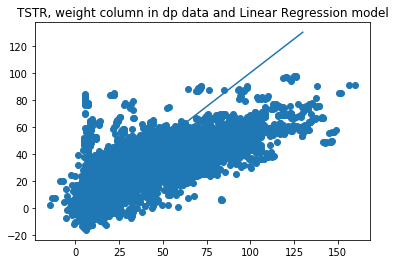

In [55]:
import matplotlib.pyplot as plt
plt.scatter(LR_dp_result['weight']['y_test'], LR_dp_result['weight']['y_pred'])
plt.plot([0,130],[0,130])
plt.title('TSTR, weight column in dp data and Linear Regression model')
plt.savefig('png_files/3.1 DWP/TSTR_weight_dp_LR.png')
plt.show()


## III. E Table
Table of $ E $ values for Linear Regression, Decision Tree Regression, Linear SVM and Random Forests models for real and synthetic data from DoppelGANger and TGANs.

In [62]:
com_t = Comparison_Table(synthetic_num_dic)
display(com_t)

'average MSE for each model and dataset'

/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

DoppelGANger ini                    tGAN                 gen 1  \
                  ori         gen         ori       gen         ori   
LR         397.302465  584.654481  377.866016  0.476782  283.391171   
DTR        780.470421  760.150714  450.651939  0.137460  360.322899   
SVM        510.113207  645.853856  408.775913  2.324619  307.446604   
RFR        400.651314  389.063142  372.215690  0.063685  235.331590   
KNR1       423.341704  477.675071  370.274312  0.758189  241.174906   
KNR5       423.341704  477.675071  370.274312  0.758189  241.174906   

                      gen 2                   gen 3                    gen 4  \
            gen         ori        gen          ori          gen         ori   
LR    13.440328  158.472269  12.470599  1746.724614  2151.200366  286.901648   
DTR    1.105395  244.731286   0.521658  2522.893514  2228.220042  357.996221   
SVM   22.786696  175.629748  27.831243  1910.814209  2769.861445  307.052334   
RFR    0.615911  162.506853   0.237857  2064.894514  1174.564824  249.576722   
KNR1   4.300220  171.673320   1.616120  1960.946963  1503.607375  241.369064   
KNR5   4.300220  171.673320   1.616120  1960.946963  1503.607375  241.369064   

                 
            gen  
LR    17.449841  
DTR    0.548723  
SVM   57.349672  
RFR    0.288801  
KNR1   1.769864  
KNR5   1.769864

In [73]:
com_t.to_csv('csv_results/3.1 DWP/IIIE Table.csv')

## Comment
We can see that models perform much better on synthetic data than the real data in the case of tGAN. This implies that the tGAN model may interpret the dependency between columns more simply than it should be.

## SRA measuring E Table

In [70]:
def SRA_TSTS_TRTR(E_table):
    df_dic = list(set(E_table.keys().get_level_values(0).tolist()))
    models = (E_table.index).tolist()
    l = len(df_dic)
    v_np = np.zeros(l)
    for n in range(l):
        key = df_dic[n]
#         i = 2*n
#         j = 2*n+1
#         k1 = df_dic[i]
#         k2 = df_dic[j]
#         P1 = Prediction(df_dic[k1])
#         P2 = Prediction(df_dic[k2])
#         for m in range(len(models)):
#             model = models[m]
        v_np[n] = SRA(E_table[key,'ori'],E_table[key,'gen'])
    display('SRA for E table')
    return pd.Series(v_np,index = df_dic)

In [72]:
sra_E = SRA_TSTS_TRTR(com_t)
display(sra_E)
sra_E.to_csv('csv_results/3.1 DWP/sra_E.csv')

'SRA for E table'

gen 1               0.733333
gen 2               0.533333
gen 3               0.400000
gen 4               0.600000
tGAN                0.466667
DoppelGANger ini    0.800000
dtype: float64

## IV. SRA measuring the list of MSEs for each column predicition results, for the specified model and synthetic data generator

In [77]:
def SRA_Comparison(df_dic,models = ['LR','DTR','SVM','RFR','KNR1','KNR5'] ):
    '''
    The dataframe values are TSTSvsTRTR SRAs which are ranking values for the accuracy of every columns, for the index model which is trained and tested on the column dataset.
    '''
    l = len(df_dic)
    v_np = np.zeros((len(models),l))
    keys = list(df_dic.keys())
    for n in range(l):
        k = keys[n]
        P1 = Prediction(df_dic[k][0])
        P2 = Prediction(df_dic[k][1])
        for m in range(len(models)):
            model = models[m]
            v_np[m][n] = SRA(P1.Evaluation_MSE(model),P2.Evaluation_MSE(model))
    display('SRA for column rankings')
    return pd.DataFrame(v_np,index = models, columns = keys)

       
    

In [78]:
sra_c = SRA_Comparison(synthetic_num_dic)
display(sra_c)

/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

'SRA for column rankings'

,DoppelGANger ini,tGAN,gen 1,gen 2,gen 3,gen 4
LR,0.9,0.866667,0.866667,0.800000,0.933333,0.800000
DTR,0.8,0.866667,0.933333,0.800000,0.933333,0.800000
SVM,0.9,0.800000,0.933333,0.866667,0.933333,0.733333
RFR,0.8,0.866667,0.933333,0.800000,0.933333,0.733333
KNR1,0.7,0.866667,0.933333,0.866667,0.933333,0.866667
KNR5,0.7,0.866667,0.933333,0.866667,0.933333,0.866667


## V. Epsilon value tables

In [79]:
def Epsilon_Table(df_dic,models = ['LR','DTR','SVM','RFR','KNR1','KNR2'] ):
    '''
    The dataframe values are TSTSvsTRTR Epsilon values for the index model and column generator.
    '''
    from sklearn.metrics import mean_squared_error
    
    l = len(df_dic)
    v_np = np.zeros((len(models),l))
    keys = list(df_dic.keys())
    for n in range(l):
        k = keys[n]
        P1 = Prediction(df_dic[k][0])
        P2 = Prediction(df_dic[k][1])
        column_length = len((df_dic[k][0].keys()).tolist())
        for m in range(len(models)):
            model = models[m]
            v_np[m][n] = mean_squared_error(P1.Evaluation_MSE(model),P2.Evaluation_MSE(model))/column_length
    display('Epsilon value table')
    return pd.DataFrame(v_np,index = models, columns = ['dp','tgan'])

In [243]:
EpsilonTable = Epsilon_Table(syn)
EpsilonTable.to_csv('csv_results/3.1 DWP/EpsilonTable.csv')
display(EpsilonTable)

/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

'Epsilon value table'

As all epsilon values of the DoppelGANger are smaller than that of the TGAN for the same predictive model, we can conclude DoppelGANger is better than TGAN in the sense of TSTS & TRTR.